# Chinook: SQL Analysis of digital music store data

In this project, we'll work with data from the [Chinook](https://github.com/lerocha/chinook-database), a fictional digital music store. 

The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store. It contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables.


## About the Database

We will now look at the schema diagram to understand the tables and its relationships.

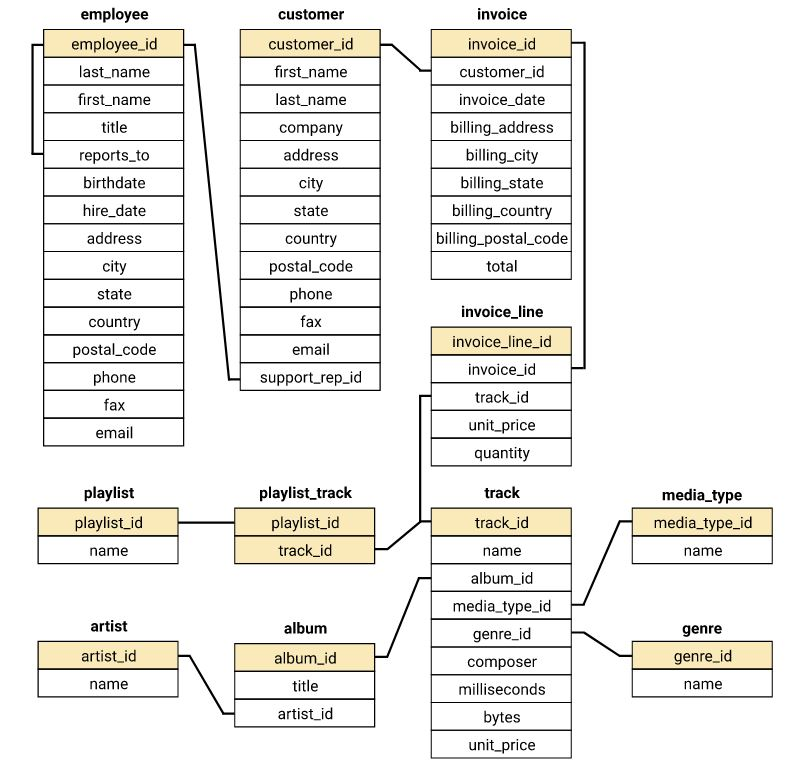

In [2]:
from IPython.display import Image
Image(filename='ChinookERD.jpg')

We will now connect this database file to our Juypter.

In [3]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [4]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ('table', 'view')

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## Data Analysis - Management Questions

### Case 1:

The Chinook record store has just signed a deal with a new record label, and we want to understand the first three albums that will be added to the store, from a list of four. 

The record label specialises in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

All four albums are by artists that don't have any tracks in the store right now - We have the artist names, and the genre of music they produce:

|Artist |Genre  |
| :- | :- |
|Regal|Hip-Hop|
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jim Bites|Blues|

In [5]:
%%sql
WITH 
    us_sales AS
        (SELECT 
             c.customer_id, 
             i.invoice_id
         FROM invoice i         
         INNER JOIN customer c ON c.customer_id = i.customer_id
         WHERE UPPER(c.country) = "USA"
        ),
    us_sales_genres AS
        (SELECT g.name genre,
                COUNT(il.invoice_line_id) num_sales
         FROM us_sales uss
         INNER JOIN invoice_line il ON il.invoice_id = uss.invoice_id
         INNER JOIN track t ON t.track_id = il.track_id
         INNER JOIN genre g ON g.genre_id = t.genre_id
         GROUP BY 1
        ),
    genre_us_final AS
        (SELECT 
             genre,
             CAST(num_sales AS Float) num_sales,
             (SELECT CAST(SUM(num_sales) AS Float) 
              FROM us_sales_genres) total_sales
         FROM us_sales_genres usg
        )
SELECT 
    genre "Genre",
    num_sales "Number of Tracks Sold",
    ROUND((num_sales/total_sales) * 100,2) "% of Total Sales"
FROM genre_us_final
ORDER BY 2 DESC

 * sqlite:///chinook.db
Done.


Genre,Number of Tracks Sold,% of Total Sales
Rock,561.0,53.38
Alternative & Punk,130.0,12.37
Metal,124.0,11.8
R&B/Soul,53.0,5.04
Blues,36.0,3.43
Alternative,35.0,3.33
Latin,22.0,2.09
Pop,22.0,2.09
Hip Hop/Rap,20.0,1.9
Jazz,14.0,1.33


From the analysis, it is clear the rock genre account for more than half of all tracks sold in the US. 

Apart from this information, we can see the listing of genres based on tracks sold in the US.

Taking this for our case to choose 3 out of the 4 artists - We should leave `Hip-Hop` genre artist behind, and go with **Red Tone**, **Meteor and the Girls**, and **Slim Jim Bites**.

### Case 2:

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase.

We have to analyse the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [6]:
%%sql
WITH 
    support_agent_sales AS
        (SELECT c.support_rep_id,
                ROUND(CAST(SUM(i.total) AS Float),2) total_sales
         FROM invoice i
         INNER JOIN customer c ON c.customer_id = i.customer_id
         GROUP BY c.support_rep_id
        )
SELECT 
    e.employee_id,
    e.first_name||' '||e.last_name employee_name,
    e.hire_date,
    e.title,
    e.email,
    mgr.first_name||' '||mgr.last_name manager_name,
    ss.total_sales
FROM employee e
INNER JOIN support_agent_sales ss ON ss.support_rep_id = e.employee_id
LEFT JOIN employee mgr ON mgr.employee_id = e.reports_to

 * sqlite:///chinook.db
Done.


employee_id,employee_name,hire_date,title,email,manager_name,total_sales
3,Jane Peacock,2017-04-01 00:00:00,Sales Support Agent,jane@chinookcorp.com,Nancy Edwards,1731.51
4,Margaret Park,2017-05-03 00:00:00,Sales Support Agent,margaret@chinookcorp.com,Nancy Edwards,1584.0
5,Steve Johnson,2017-10-17 00:00:00,Sales Support Agent,steve@chinookcorp.com,Nancy Edwards,1393.92


Looking at the **total_sales** by the sales support agent, we can see that the more experienced they are (Based on <mark>hire_date</mark>), higher their total_sales.

### Case 3:

We are required to analyse the sales data for customers from each different country and present it *sorted by Total Sales Value* so that we can sales by countries from highest to lowest.

In particular, we have been directed to calculate data, for each country, on the:

- Total number of customers
- Total value of sales
- Average value of sales per customer
- Average order value

**Note**: Because there are a number of countries with only one customer, we are asked to  group these customers as "Other" in result and make that as the last record.

In [7]:
%%sql
WITH 
    country_sales AS
    (
        SELECT    
            c.country,
            COUNT(DISTINCT c.customer_id) total_customers,
            COUNT(i.invoice_id) total_sales,
            CAST(SUM(i.total) AS Float) total_sales_value
        FROM invoice i
        INNER JOIN customer c ON c.customer_id = i.customer_id
        GROUP BY
            c.country
    )
SELECT
    country "Country",
    total_customers "Total Customers",    
    ROUND(total_sales_value,2) "Total Sales Value",
    ROUND((total_sales_value / total_customers),2) "Average Customer Sales Value",
    ROUND((total_sales_value / total_sales),2) "Average Order Value"
FROM (
        SELECT 
            CASE 
                WHEN total_customers > 1 THEN
                    country
                ELSE
                    "Other"
            END country,
            CASE WHEN total_customers > 1 THEN
                1
            ELSE
                0
            END sort,
            SUM(total_customers) total_customers,
            SUM(total_sales) total_sales,
            SUM(total_sales_value) total_sales_value
        FROM country_sales
        GROUP BY 1,2
     )
ORDER BY sort desc,3 desc;

 * sqlite:///chinook.db
Done.


Country,Total Customers,Total Sales Value,Average Customer Sales Value,Average Order Value
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.58,8.72
Other,15,1094.94,73.0,7.45


1. US and Canada (North America) score high on total customers by sales
2. However, by Average Customer Sales Value, Czech Republic and Portugal score high

### Case 4:

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [8]:
%%sql
WITH 
    invoice_album_stat AS
        (
            SELECT 
                is_album_purchase, 
                CAST(COUNT(*) AS Float) number_of_invoices
            FROM (
                    WITH 
                        invoice_track_albums AS
                            (SELECT 
                                 il.invoice_id, 
                                 t.album_id, 
                                 t.track_id
                             FROM invoice_line il
                             INNER JOIN track t ON t.track_id = il.track_id
                            )
                    SELECT i.invoice_id,
                           (
                               CASE WHEN 
                                       (
                                        SELECT ita.track_id
                                        FROM invoice_track_albums ita
                                        WHERE ita.invoice_id = i.invoice_id
                                           EXCEPT
                                        SELECT t.track_id
                                        FROM track t
                                        INNER JOIN album a ON a.album_id = t.album_id
                                        WHERE a.album_id IN (SELECT ita.album_id
                                                             FROM invoice_track_albums ita
                                                             WHERE ita.invoice_id = i.invoice_id
                                                            )
                                       ) IS NULL
                                       AND
                                       (
                                        SELECT t.track_id
                                        FROM track t
                                        INNER JOIN album a ON a.album_id = t.album_id
                                        WHERE a.album_id IN (SELECT ita.album_id
                                                             FROM invoice_track_albums ita
                                                             WHERE ita.invoice_id = i.invoice_id
                                                            )
                                           EXCEPT
                                        SELECT ita.track_id
                                        FROM invoice_track_albums ita
                                        WHERE ita.invoice_id = i.invoice_id 
                                       ) IS NULL
                                   THEN 'Y'
                                   ELSE 'N'
                               END
                           ) is_album_purchase
                    FROM invoice i
                )
            GROUP BY is_album_purchase
        )
SELECT 
    CASE
        WHEN is_album_purchase = "Y" THEN "Whole Album"
        ELSE "Individual Tracks"
    END "Purchase Type", 
    number_of_invoices "Number of Invoices",
    ROUND((number_of_invoices 
           / 
           (SELECT SUM(number_of_invoices)
            FROM invoice_album_stat)
          ) * 100
          ,2) "Percentage of Invoices"
FROM invoice_album_stat

 * sqlite:///chinook.db
Done.


Purchase Type,Number of Invoices,Percentage of Invoices
Individual Tracks,500.0,81.43
Whole Album,114.0,18.57


From the statistics above, it will clear more than **80%** of sales have been individual tracks rather than full album.

Based on this, the **strategy to purchase only the most popular tracks from each album** from record companies, instead of purchasing every track from an album **will not have a major detriment** to their sales.

Hence they should go ahead with their strategy to reduce purchasing costs.

### Case 5: 

Head of Digital Marketing wants to create trivia content for better engagement through their social media channels - So wants to know the following:

1. Which artist is used in most playlist?
2. Top 10 tracks sold - Along with its album/artist?

In [9]:
%%sql
SELECT  
    ar.name artist,
    COUNT(DISTINCT plt.playlist_id) number_of_playlists,
    COUNT(DISTINCT plt.track_id) number_of_tracks_in_playlists
FROM track t
INNER JOIN playlist_track plt ON plt.track_id = t.track_id
INNER JOIN album a ON a.album_id = t.album_id
INNER JOIN artist ar ON ar.artist_id = a.artist_id
GROUP BY ar.name
ORDER BY 2 DESC

 * sqlite:///chinook.db
Done.


artist,number_of_playlists,number_of_tracks_in_playlists
Eugene Ormandy,7,3
The King's Singers,6,2
English Concert & Trevor Pinnock,6,2
Berliner Philharmoniker & Herbert Von Karajan,6,3
Academy of St. Martin in the Fields & Sir Neville Marriner,6,2
Yo-Yo Ma,5,1
Wilhelm Kempff,5,1
Ton Koopman,5,1
"Sir Georg Solti, Sumi Jo & Wiener Philharmoniker",5,1
Sir Georg Solti & Wiener Philharmoniker,5,1


It seems like **Eugene Ormandy** is the artist most added to the various playlist based on the tracks.

Next let's look at the top 10 tracks based on the sales along with album/artist the track belong to.

In [10]:
%%sql
SELECT
    DISTINCT 
    t.name track_name,
    COUNT() OVER (PARTITION BY il.track_id) track_sold_count,
    (SELECT ar.name||' ('||a.title||')'
        FROM album a
        INNER JOIN artist ar ON ar.artist_id = a.artist_id
        WHERE a.album_id = t.album_id) "Artist (Album)"
FROM invoice_line il
INNER JOIN track t ON t.track_id = il.track_id
ORDER BY 2 DESC
LIMIT 10;

 * sqlite:///chinook.db
Done.


track_name,track_sold_count,Artist (Album)
War Pigs,31,Cake (Cake: B-Sides and Rarities)
Are You Experienced?,14,Jimi Hendrix (Are You Experienced?)
Highway Chile,14,Jimi Hendrix (Are You Experienced?)
Put The Finger On You,13,AC/DC (For Those About To Rock We Salute You)
Third Stone From The Sun,13,Jimi Hendrix (Are You Experienced?)
Hey Joe,13,Jimi Hendrix (Are You Experienced?)
Love Or Confusion,12,Jimi Hendrix (Are You Experienced?)
Radio/Video,12,System Of A Down (Mezmerize)
Dead And Broken,11,Godsmack (Faceless)
Foxy Lady,11,Jimi Hendrix (Are You Experienced?)


Based on sales we see the Top 10 tracks above:
1. **War Pigs** by Cake (Band) is the top
2. However, the Top 10 list is dominated by **Jimi Hendrix's tracks** from "Are you Experienced?" (6 out of 10 tracks)

### Case 6:

Management wants to see how many tracks in the store are purchased vs not purchased. 

This way they can do a further analysis on cutting purchasing costs or doing promotion on the tracks not purchased etc.,

In [11]:
%%sql
WITH
    track_purchase_status AS
        (
            SELECT 
                t.name track_name,
                CASE
                    WHEN EXISTS (SELECT 1
                                 FROM invoice_line il
                                 WHERE il.track_id = t.track_id) THEN 'Purchased'
                    ELSE 'Not Purchased'
                END purchase_status
            FROM track t
        )
SELECT
    purchase_status "Purchase Status",
    num_tracks "Number of Tracks",
    ROUND((num_tracks / (SELECT COUNT(*) 
                  FROM track_purchase_status) * 100),2) "Percentage of Tracks"
FROM (
        SELECT purchase_status,
               CAST(COUNT(*)  AS Float) num_tracks
        FROM track_purchase_status
        GROUP BY 1
     )
ORDER BY 1 Desc


 * sqlite:///chinook.db
Done.


Purchase Status,Number of Tracks,Percentage of Tracks
Purchased,1806.0,51.56
Not Purchased,1697.0,48.44


### Case 7:

Management wants to see:
1. How many tracks in the store are Protected vs Non-protected media types
2. If media type have an effect on sales/popularity?

In [12]:
%%sql
WITH 
    track_media_type AS 
        (
            SELECT CASE 
                        WHEN m.name LIKE 'Protected%' THEN
                            'Protected'
                        ELSE 'Non-Protected'
                   END media_type_classification,
                   COUNT(*) number_of_tracks
            FROM track t
            INNER JOIN media_type m ON m.media_type_id = t.media_type_id
            GROUP BY 1
        )
SELECT 
    media_type_classification "Media Type Classfication",
    number_of_tracks "Number of tracks",
    ROUND(CAST(number_of_tracks AS Float) / (SELECT SUM(number_of_tracks)
                                       FROM track_media_type) 
         ,2) * 100 "Percentage of tracks"
FROM track_media_type


 * sqlite:///chinook.db
Done.


Media Type Classfication,Number of tracks,Percentage of tracks
Non-Protected,3052,87.0
Protected,451,13.0


It seems like **87%** of the tracks in our store are Non-protected media type. That's the majority.

Now, let's see how this media type especially "Protected vs Non-Protected" media types play out in our sales.

In [16]:
%%sql
WITH 
    media_type_sales AS 
        (
            SELECT 
                   CASE 
                        WHEN m.name LIKE 'Protected%' THEN
                            'Protected'
                        ELSE 'Non-Protected'
                   END media_type_classification,
                   COUNT(DISTINCT il.track_id) unique_tracks_sold,
                   COUNT(*) numbers_sold
            FROM invoice_line il
            INNER JOIN track t ON t.track_id = il.track_id
            INNER JOIN media_type m ON m.media_type_id = t.media_type_id
            GROUP BY 1
        ),
    track_media_type AS 
        (
            SELECT CASE 
                        WHEN m.name LIKE 'Protected%' THEN
                            'Protected'
                        ELSE 'Non-Protected'
                   END media_type_classification,
                   COUNT(*) number_of_tracks
            FROM track t
            INNER JOIN media_type m ON m.media_type_id = t.media_type_id
            GROUP BY 1
        )
SELECT 
    ms.media_type_classification "Media Type Classfication",
    mt.number_of_tracks "Total Tracks in Store",
    ms.unique_tracks_sold "Tracks Sold",
    mt.number_of_tracks - ms.unique_tracks_sold "Tracks Not Sold",
    ROUND(CAST(ms.unique_tracks_sold AS Float)/mt.number_of_tracks,2) * 100 "Percentage of Tracks Sold"
FROM media_type_sales ms
INNER JOIN track_media_type mt ON mt.media_type_classification = ms.media_type_classification
ORDER BY 1

 * sqlite:///chinook.db
Done.


Media Type Classfication,Total Tracks in Store,Tracks Sold,Tracks Not Sold,Percentage of Tracks Sold
Non-Protected,3052,1652,1400,54.0
Protected,451,154,297,34.0


## Conclusion

We explored our music store data through SQL, and answered a range of questions/cases for the management such as:
1. Whether purchase strategy of individual tracks vs whole album driven by how sales would be affected
2. Purchased vs Non-purchased tracks to drive our digital channels promotions

and many more...

We have set a good foundation for data driven business decisions for chinook digital music store.